In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import stats
from config import api_key
from pprint import pprint

In [2]:
url = 'https://api.covidtracking.com/v1/states/mi/daily.json'
response = (requests.get(url).json())
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Creating and cleaning DataFrame
covid_df = pd.DataFrame(response)
covid_df.dropna(axis=1, how='all', inplace = True)
del covid_df['hospitalizedIncrease'],covid_df['hash'],covid_df['commercialScore'],covid_df['negativeRegularScore'],covid_df['negativeScore'],covid_df['positiveScore'],covid_df['score'],covid_df['grade']
covid_df = covid_df.drop(columns = ['lastUpdateEt','dateModified','checkTimeEt','recovered','dataQualityGrade','totalTestResultsSource','dateChecked'])
covid_df.head()

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestsAntibody,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease
0,20200928,MI,135702,3458288.0,NaN,3593990,557.0,137.0,51.0,7051.0,3629903.0,171615.0,3458288.0,122735,6731.0,320,292255.0,26,1329,49604,3593990,50933,3593990,7
1,20200927,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,0,0,3543057,0,3543057,0
2,20200926,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,996,39749,3543057,40745,3543057,17
3,20200925,MI,133377,3368935.0,NaN,3502312,558.0,139.0,52.0,7027.0,3537643.0,168708.0,3368935.0,120526,6708.0,319,289151.0,26,1040,38448,3502312,39488,3502312,8
4,20200924,MI,132337,3330487.0,NaN,3462824,558.0,139.0,50.0,7019.0,3498071.0,167584.0,3330487.0,119597,6700.0,319,288257.0,26,1078,36639,3462824,37717,3462824,6


In [4]:
# Trying to create consistent datetime column ot use with merge.
covid_dates = [datetime.date(int(str(x)[0:4]), int(str(x)[5]), int(str(x)[6:8])) for x in covid_df['date']]
covid_df['datetimes']=covid_dates
covid_df.head()


,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestsAntibody,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,datetimes
0,20200928,MI,135702,3458288.0,NaN,3593990,557.0,137.0,51.0,7051.0,3629903.0,171615.0,3458288.0,122735,6731.0,320,292255.0,26,1329,49604,3593990,50933,3593990,7,2020-09-28
1,20200927,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,0,0,3543057,0,3543057,0,2020-09-27
2,20200926,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,996,39749,3543057,40745,3543057,17,2020-09-26
3,20200925,MI,133377,3368935.0,NaN,3502312,558.0,139.0,52.0,7027.0,3537643.0,168708.0,3368935.0,120526,6708.0,319,289151.0,26,1040,38448,3502312,39488,3502312,8,2020-09-25
4,20200924,MI,132337,3330487.0,NaN,3462824,558.0,139.0,50.0,7019.0,3498071.0,167584.0,3330487.0,119597,6700.0,319,288257.0,26,1078,36639,3462824,37717,3462824,6,2020-09-24


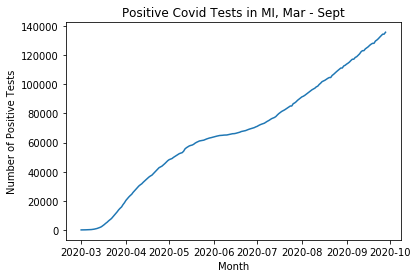

In [5]:
plt.plot(covid_df['datetimes'], covid_df['positive'])
plt.title('Positive Covid Tests in MI, Mar - Sept')
plt.ylabel('Number of Positive Tests')
plt.xlabel('Month')
plt.show()

In [6]:
emp_comb_path = 'Resources/data/Employment Combined - State - Daily.csv'
emp_comb_df = pd.read_csv(emp_comb_path)
mi_emp_comb_df = emp_comb_df.loc[emp_comb_df['statefips']==26] #MI fips is 26
mi_emp_comb_df.head()

,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70
22,2020,1,15,26,-0.001230,-.000268,-.00115,-0.00255,-.000196,-.00234,.000193,-.00555
73,2020,1,16,26,-0.000679,.000682,-.000624,-0.00245,-.000276,-.0022,.000653,-.00418
124,2020,1,17,26,-0.000132,.00163,-.0000949,-0.00235,-.000307,-.00203,.00112,-.00278
175,2020,1,18,26,0.000427,.00262,.000434,-0.00226,-.000312,-.00186,.00164,-.00117
226,2020,1,19,26,0.000985,.00361,.000963,-0.00216,-.000317,-.00169,.00215,.000433


In [7]:
mi_emp_comb_df['number employed'] = (mi_emp_comb_df.iloc[:, 4] * 4774000)+4774000
mi_emp_comb_df

C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,number employed
22,2020,1,15,26,-0.001230,-.000268,-.00115,-0.002550,-.000196,-.00234,.000193,-.00555,4768127.980
73,2020,1,16,26,-0.000679,.000682,-.000624,-0.002450,-.000276,-.0022,.000653,-.00418,4770758.454
124,2020,1,17,26,-0.000132,.00163,-.0000949,-0.002350,-.000307,-.00203,.00112,-.00278,4773369.832
175,2020,1,18,26,0.000427,.00262,.000434,-0.002260,-.000312,-.00186,.00164,-.00117,4776038.498
226,2020,1,19,26,0.000985,.00361,.000963,-0.002160,-.000317,-.00169,.00215,.000433,4778702.390
277,2020,1,20,26,0.001540,.0046,.00149,-0.002070,-.000322,-.00152,.00267,.00204,4781351.960
328,2020,1,21,26,0.002050,.00539,.00202,-0.001970,-.000369,-.00136,.00313,.00331,4783786.700
379,2020,1,22,26,0.002550,.00618,.00255,-0.001870,-.000388,-.00118,.00358,.00452,4786173.700
430,2020,1,23,26,0.002600,.00595,.00252,-0.001320,-.000475,-.000452,.00355,.00498,4786412.400
481,2020,1,24,26,0.002610,.00558,.00249,-0.000773,-.000606,.000234,.00348,.00538,4786460.140


In [8]:
# Change in employment as percent
mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']]= mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']].astype(float)*100
mi_emp_comb_df.head().style.format({'emp_combined': '{0:,.5f}%'})

C:\Users\state\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,number employed
22,2020,1,15,26,-0.12300%,-0.026800,-0.115000,-0.255000,-.000196,-.00234,.000193,-.00555,4768127.980000
73,2020,1,16,26,-0.06790%,0.068200,-0.062400,-0.245000,-.000276,-.0022,.000653,-.00418,4770758.454000
124,2020,1,17,26,-0.01320%,0.163000,-0.009490,-0.235000,-.000307,-.00203,.00112,-.00278,4773369.832000
175,2020,1,18,26,0.04270%,0.262000,0.043400,-0.226000,-.000312,-.00186,.00164,-.00117,4776038.498000
226,2020,1,19,26,0.09850%,0.361000,0.096300,-0.216000,-.000317,-.00169,.00215,.000433,4778702.390000


C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\state\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


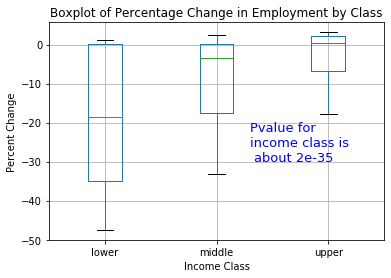

In [62]:
mi_emp_comb_df['emp_expected'] = mi_emp_comb_df['emp_combined'].mean()
mi_emp_comb_df

low = mi_emp_comb_df['emp_combined_inclow']
middle = mi_emp_comb_df['emp_combined_incmiddle']
high = mi_emp_comb_df['emp_combined_inchigh']
annova = (stats.f_oneway(low, middle, high))


mi_emp_comb_df[['lower', 'middle', 'upper']]=mi_emp_comb_df[['emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh']]
mi_emp_comb_df.boxplot(['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.title('Boxplot of Percentage Change in Employment by Class')
plt.xlabel('Income Class')
plt.annotate(f'Pvalue for \nincome class is \n about {round(annova[1], 35)}', (2.3, -30), fontsize = 13, color = 'blue')
plt.show()

#Alternative
#in the last six months, lower class was affected more by covid 19 than any other class

# Null
# in the last six months, employment is uncorrellated with income level throughout the pandemic.


C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


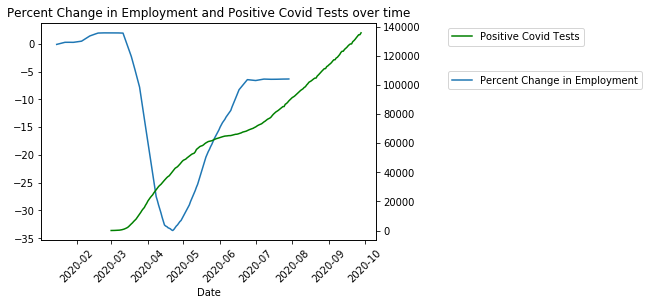

In [10]:
date = []
per_change = []
#Creating consistent datetime
for index in mi_emp_comb_df.index:
    date.append(datetime.date(mi_emp_comb_df.loc[index, 'year'],mi_emp_comb_df.loc[index, 'month'],mi_emp_comb_df.loc[index, 'day']))
    per_change.append(mi_emp_comb_df.loc[index, 'emp_combined'])
mi_emp_comb_df['datetimes'] = date


x_values = date
y_values = per_change

fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.plot(x_values, y_values)
plt.xticks(rotation = 45)
plt.legend(labels = ['Percent Change in Employment'], bbox_to_anchor=(1.2, .8), loc='upper left')
ax2  = ax1.twinx()
ax2.plot(covid_df['datetimes'], covid_df['positive'], color = 'green')
ax2.legend(labels = ['Positive Covid Tests'], bbox_to_anchor=(1.2, 1), loc='upper left')
plt.title('Percent Change in Employment and Positive Covid Tests over time')
plt.show()





# x_values = date
# y_values = per_change


# fig1  = plt.plot(x_values, y_values)
# fig2 = plt.plot(covid_df['datetimes'], covid_df['positive'])
# plt.xlabel('Months')
# plt.ylabel('Percent Change')
# plt.title('Percentage Change in Employment Levels Compared to January 4-31, 2020', color = 'red')
# plt.show()



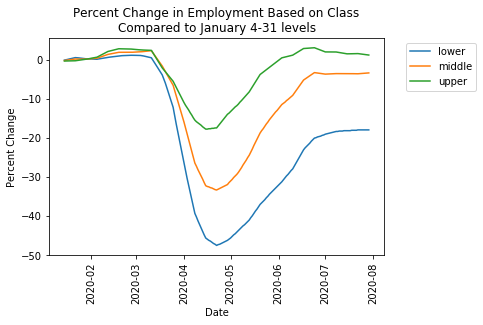

In [11]:

mi_emp_comb_df.plot('datetimes', ['emp_combined_inclow' , 'emp_combined_incmiddle', 'emp_combined_inchigh'], kind = 'line')
plt.title('Percent Change in Employment Based on Class\nCompared to January 4-31 levels')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels = ['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.show()

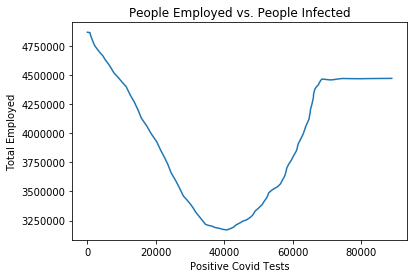

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestsAntibody,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,datetimes,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,number employed,emp_expected
0,20200729,MI,88974,1704259.0,NaN,1793233,670.0,195.0,135.0,6422.0,1819805.0,115546.0,1704259.0,80172,6172.0,250,210763.0,26,1016,64335,1793233,65351,1793233,1,2020-07-29,2020,7,29,26,-6.34,-17.9,-3.30,1.28,-.0685,-.0537,-.107,-.098,4471328.4,-10.851375
1,20200728,MI,87958,1639924.0,NaN,1727882,670.0,195.0,135.0,6421.0,1751875.0,111951.0,1639924.0,79176,6170.0,251,209655.0,26,785,26608,1727882,27393,1727882,16,2020-07-28,2020,7,28,26,-6.35,-17.9,-3.33,1.34,-.0688,-.0544,-.107,-.0988,4470851.0,-10.851375
2,20200727,MI,87173,1613316.0,NaN,1700489,670.0,195.0,113.0,6405.0,1723892.0,110576.0,1613316.0,78507,6154.0,251,208729.0,26,512,29233,1700489,29745,1700489,5,2020-07-27,2020,7,27,26,-6.35,-17.9,-3.36,1.39,-.069,-.0551,-.107,-.0997,4470851.0,-10.851375
3,20200726,MI,86661,1584083.0,NaN,1670744,680.0,210.0,113.0,6400.0,1693712.0,109629.0,1584083.0,78019,6149.0,251,207540.0,26,1589,54509,1670744,56098,1670744,0,2020-07-26,2020,7,26,26,-6.35,-17.9,-3.40,1.44,-.0693,-.0559,-.107,-.101,4470851.0,-10.851375
4,20200725,MI,85072,1529574.0,NaN,1614646,751.0,215.0,113.0,6400.0,1637017.0,107443.0,1529574.0,76541,6151.0,249,204810.0,26,0,0,1614646,0,1614646,0,2020-07-25,2020,7,25,26,-6.36,-17.9,-3.43,1.49,-.0696,-.0566,-.106,-.101,4470373.6,-10.851375


In [12]:
covid_emp_merge = pd.merge(covid_df, mi_emp_comb_df, on='datetimes', how = 'inner')

x_values = covid_emp_merge['positive']
y_values = covid_emp_merge['number employed']
plt.plot(x_values, y_values)
plt.title('People Employed vs. People Infected')
plt.ylabel('Total Employed')
plt.xlabel('Positive Covid Tests')
plt.show()
covid_emp_merge.head()

In [13]:
dol_path = 'Resources/MI_DOL_EMP_STATS.csv'
dol_emp_df = pd.read_csv(dol_path, encoding='UTF-8')
dol_emp_df = dol_emp_df.sort_values(['Period Year (copy)', 'PeriodCode (copy)'] ,ascending=False)
unadjusted = dol_emp_df.loc[(dol_emp_df['Adjustment'] == 'Not Adj') & (dol_emp_df['Year'] == 2020)]
unadjusted['PeriodCode']+= 1
unadjusted

C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Period Year (copy),PeriodCode (copy),ID,Region,Area,Year,Period,Adjustment,Preliminary,Area Type,Period Type Description,StateSelected,Adjusted,PeriodCode,Prelim,State Code,State Name,Employed,Labor Force,Unemployed,Unemployment Rate
9,2020,8,3403524,MI,Michigan,2020,August,Not Adj,Yes,State,Monthly,True,0,9,1,26,Michigan,"4,502,000","4,941,000","440,000",8.9
2,2020,7,3403522,MI,Michigan,2020,July,Not Adj,No,State,Monthly,True,0,8,0,26,Michigan,"4,406,000","4,871,000","465,000",9.5
50,2020,6,3403520,MI,Michigan,2020,June,Not Adj,No,State,Monthly,True,0,7,0,26,Michigan,"4,240,000","4,988,000","748,000",15.0
47,2020,5,3403518,MI,Michigan,2020,May,Not Adj,No,State,Monthly,True,0,6,0,26,Michigan,"3,773,000","4,765,000","992,000",20.8
44,2020,4,3403516,MI,Michigan,2020,April,Not Adj,No,State,Monthly,True,0,5,0,26,Michigan,"3,477,000","4,553,000","1,076,000",23.6
65,2020,3,3403514,MI,Michigan,2020,March,Not Adj,No,State,Monthly,True,0,4,0,26,Michigan,"4,702,000","4,900,000","198,000",4.0
62,2020,2,3403512,MI,Michigan,2020,February,Not Adj,No,State,Monthly,True,0,3,0,26,Michigan,"4,774,000","4,953,000","180,000",3.6
59,2020,1,3403510,MI,Michigan,2020,January,Not Adj,No,State,Monthly,True,0,2,0,26,Michigan,"4,714,000","4,924,000","211,000",4.3


In [14]:
# single_df = pd.DataFrame(columns =['date', 'state', 'positive', 'negative', 'pending', 'totalTestResults', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'death', 'totalTestsViral', 'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral', 'deathConfirmed', 'deathProbable', 'totalTestsAntibody', 'fips', 'positiveIncrease', 'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg', 'deathIncrease', 'datetimes'] )
# for index, row in covid_df.iterrows():
#     if '01' in str(row['date']):
#         single_df = single_df.append(row)
# single_df
# code = np.arange(9,2, -1)

# single_df['PeriodCode'] = code

# covid_dol_merge = pd.merge(single_df, unadjusted, on = 'PeriodCode', how = 'inner')
# covid_dol_merge['New Unemployed Column'] = [int(x.replace(',', '')) for x in covid_dol_merge['Unemployed']]

# covid_dol_merge.plot('positive', 'New Unemployed Column', kind = 'scatter')
# plt.ylabel('Unemployed')
# plt.xlabel('Covid Positive Tests')
# plt.title('Unemployed vs. Positive Covid Tests')
# plt.show()



In [15]:
covid_df.head()

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestsAntibody,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,datetimes
0,20200928,MI,135702,3458288.0,NaN,3593990,557.0,137.0,51.0,7051.0,3629903.0,171615.0,3458288.0,122735,6731.0,320,292255.0,26,1329,49604,3593990,50933,3593990,7,2020-09-28
1,20200927,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,0,0,3543057,0,3543057,0,2020-09-27
2,20200926,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,996,39749,3543057,40745,3543057,17,2020-09-26
3,20200925,MI,133377,3368935.0,NaN,3502312,558.0,139.0,52.0,7027.0,3537643.0,168708.0,3368935.0,120526,6708.0,319,289151.0,26,1040,38448,3502312,39488,3502312,8,2020-09-25
4,20200924,MI,132337,3330487.0,NaN,3462824,558.0,139.0,50.0,7019.0,3498071.0,167584.0,3330487.0,119597,6700.0,319,288257.0,26,1078,36639,3462824,37717,3462824,6,2020-09-24


Series IDs for BLS datasets
SMU26000000000000001 State and Area Employment, Hours, and Earnings
SMU26000000500000001
SMU26000000500000002
SMU26000000500000011
SMU26000000600000001
SMU26000000600000002
SMU26000000600000011
SMU26000000700000001
SMU26000000800000001
SMU26000000800000002
SMU26000000800000011



In [16]:
#Accessing API based on Documentation, must dig deep into website to find relevant information
# blsApi_url = 'https://api.bls.gov/publicAPI/v2/surveys'


blsApi_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
headers = {'Content-type': 'application/json'}
data =  json.dumps({"seriesid": ['SMU26000000000000001', 'SMU26000000500000001', 'SMU26000000500000002', 'SMU26000000500000011', 'SMU26000000600000001', 'SMU26000000600000002', 'SMU26000000600000011', 'SMU26000000700000001', 'SMU26000000800000001', 'SMU26000000800000002', 'SMU26000000800000011'],
                    'catalog':True,
                    "registrationkey" : f'{api_key}'})
bls_json = (requests.post(blsApi_url, data=data, headers = headers).json())
# pprint(bls_json['Results']['series'])
# https://www.bls.gov/developers/api_python.htm#python2


In [17]:
#Data Parsing
dframes = {}
# Loop creates dictionary dframes with keys being Commerce Industry + Measure Data Type from metadata and values are pandas dataframes
for series in bls_json['Results']['series']:
    dframes.update({series['catalog']['commerce_industry'] +' '+ series['catalog']['measure_data_type']:pd.DataFrame(series['data'])})
full_bls_df = dframes['Total Nonfarm All Employees, In Thousands']
for df_name, value_df in dframes.items():
    full_bls_df[df_name] = value_df['value']
full_bls_df = full_bls_df.drop(columns=['value', 'latest', 'footnotes'])
full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))]=full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))].astype(float)
full_bls_df.head()

,year,period,periodName,"Total Nonfarm All Employees, In Thousands","Total Private All Employees, In Thousands",Total Private Average Weekly Hours of All Employees,"Total Private Average Weekly Earnings of All Employees, In Dollars","Goods Producing All Employees, In Thousands",Goods Producing Average Weekly Hours of All Employees,"Goods Producing Average Weekly Earnings of All Employees, In Dollars","Service-Providing All Employees, In Thousands","Private Service Providing All Employees, In Thousands",Private Service Providing Average Weekly Hours of All Employees,"Private Service Providing Average Weekly Earnings of All Employees, In Dollars"
0,2020,M08,August,3983.1,3437,34.8,958.39,756.4,40.6,1175.37,3226.7,2680.6,33.2,898.39
1,2020,M07,July,3924.8,3398.1,34.4,935.34,750.3,39.8,1125.94,3174.5,2647.8,32.8,879.7
2,2020,M06,June,3889.6,3333.6,34.3,936.73,743.5,39.4,1108.32,3146.1,2590.1,32.8,886.58
3,2020,M05,May,3598.5,3034.5,34.1,955.82,635.3,38.4,1111.68,2963.2,2399.2,32.9,912.98
4,2020,M04,April,3391.2,2798.6,32.6,935.95,539.7,36.7,1088.16,2851.5,2258.9,31.7,901.87


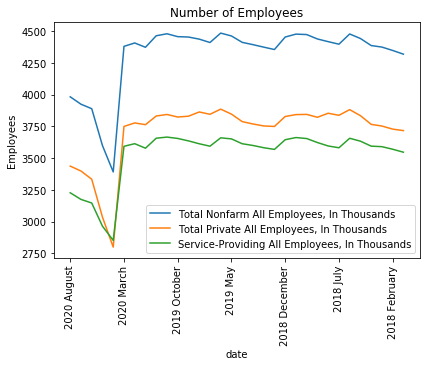

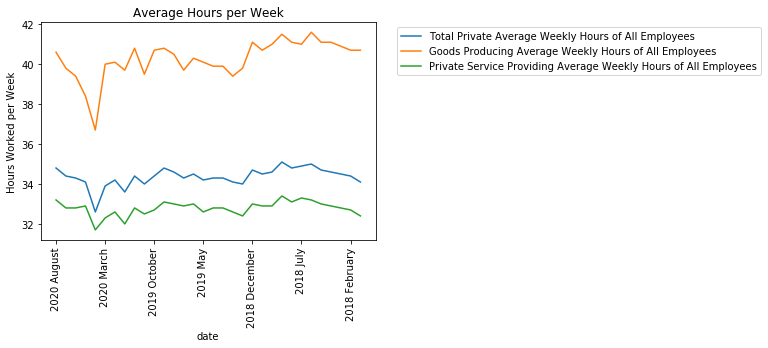

In [18]:
full_bls_df['date'] = full_bls_df['year']+' ' +full_bls_df['periodName']
full_bls_df.plot('date',['Total Nonfarm All Employees, In Thousands','Total Private All Employees, In Thousands', 'Service-Providing All Employees, In Thousands' ],  kind = 'line')
plt.tight_layout()
plt.title('Number of Employees')
plt.xticks(rotation = 90)
plt.ylabel('Employees')
full_bls_df.plot('date', ['Total Private Average Weekly Hours of All Employees', 'Goods Producing Average Weekly Hours of All Employees', 'Private Service Providing Average Weekly Hours of All Employees' ], kind = 'line')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 90)
plt.ylabel('Hours Worked per Week')
plt.title('Average Hours per Week')
plt.show()

In [19]:
geo_path = 'Resources/data/GeoIDs - County.csv'
county_covid_path = 'Resources/data/COVID - County - Daily.csv'
geo_id_df = pd.read_csv(geo_path)
county_covid_df = pd.read_csv(county_covid_path)
mi_county_id_df = geo_id_df.loc[geo_id_df['statename']=='Michigan']
mi_county_covid_df = pd.merge(county_covid_df, mi_county_id_df, on='countyfips', how='inner')



C:\Users\state\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
